In [143]:
!pip3 install matplotlib
!pip3 install sklearn

     |████████████████████████████████| 6.8 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 15.5 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=6d8b5ae3ca42bcdce5245cbee23e4a70fe072d7b5967628e19a39e05dd31c71f
  Stored in directory: /home/flagg/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [136]:
import time
import numpy as np
import pandas as pd
import turicreate as tc
import matplotlib.pyplot as plt
tc??

### data exploration

unique reviewers: 39239 
unique items: 	  19914
num_ratings: 	  200000   
rating sparcity:  0.99974



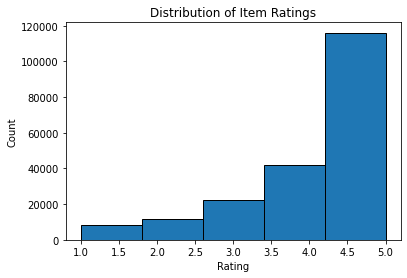

In [10]:
data = pd.read_csv("train_tab_delimited.txt", sep='\t')

# print some structure details
num_reviewers = data['reviewerID'].unique().shape[0]
num_items = data['itemID'].unique().shape[0]
num_ratings = len(data)
sparsity = 1 - num_ratings / (num_reviewers * num_items)
print("unique reviewers: {} \nunique items: \t  {}\nnum_ratings: \t  {}   \nrating sparcity:  {}\n".format(
    num_reviewers, 
    num_items, 
    num_ratings, 
    round(sparsity, 5))) # note, the data is extremely sparse

# display distribution of ratings, it is bias toward higher ratings
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Item Ratings')
plt.show()

In [137]:
data.head(5)

,reviewTime,reviewText,helpful_ratio,helpful,helpful_outOf,reviewerID,reviewHash,categories,unixReviewTime,itemID,price,rating,summary,categoryID
0,"12, 12, 2012","""I was a little afraid to get since the price ...",-1.0,0,0,U829827806,R363782763,"[['Clothing, Shoes & Jewelry', 'Women'], ['Clo...",1355270400,I999917660,0.24,5,Awesome,0
1,"02, 6, 2013","""I wear this at zumba ..in the summer months.....",-1.0,0,0,U183746108,R127989112,"[['Clothing, Shoes & Jewelry', 'Women'], ['Clo...",1360108800,I999917660,0.24,5,scarf,0
2,"01, 14, 2013","""I bought this scarf for my Zumba classes. It ...",-1.0,0,0,U146313905,R683302492,"[['Clothing, Shoes & Jewelry', 'Women'], ['Clo...",1358121600,I999917660,0.24,5,Cute Scarf,0
3,"08, 4, 2013","""The belly dance hip scarf is beautiful, well ...",1.0,4,4,U888802715,R449569320,"[['Clothing, Shoes & Jewelry', 'Women'], ['Clo...",1375574400,I999917660,0.24,3,Beautiful but stinky,0
4,"11, 23, 2013","""This is extremely beautiful and make a lot of...",-1.0,0,0,U935282947,R198932892,"[['Clothing, Shoes & Jewelry', 'Women'], ['Clo...",1385164800,I999917660,0.24,5,Belly Lady waist scarf,0


### create sparse array

In [138]:
start = time.time()

# generate list of numeric id mappings for item ids values
unique_items = data['itemID'].unique()
item_ids = np.arange(len(unique_items)).astype('float32')
item_dict = dict(zip(unique_items, item_ids))
len(item_dict)

cols = []
for i, j in data.iterrows():
    itemID = data['itemID'][i]
    cols.append(item_dict[itemID])

# generate list of numeric id mappings for reviewer ids values
unique_reviewers = data['reviewerID'].unique()
reviewer_ids = np.arange(len(unique_reviewers)).astype('float32')
reviewer_dict = dict(zip(unique_reviewers, reviewer_ids))
len(reviewer_dict)

rows = []
for i, j in data.iterrows():
    reviewer_id = data['reviewerID'][i]
    rows.append(reviewer_dict[reviewer_id])
    
end = time.time()
print("time to execute: {}".format(end-start))

# get list of rating values
ratings = data['rating'].astype('float32').tolist()

time to execute: 31.765388250350952


In [139]:
replaced_df = pd.DataFrame(zip(rows, cols, ratings))
replaced_df.head(100)

,0,1,2
0,0.0,0.0,5.0
1,1.0,0.0,5.0
2,2.0,0.0,5.0
3,3.0,0.0,3.0
4,4.0,0.0,5.0
...,...,...,...
95,95.0,7.0,5.0
96,96.0,8.0,5.0
97,97.0,8.0,4.0
98,98.0,8.0,4.0


In [140]:
from scipy import sparse
replaced_df.columns = ['user_index', 'item_index', 'rating']
matrix = replaced_df.pivot(index='user_index', columns='item_index', values='rating')
matrix = matrix.fillna(0)
user_item_matrix = sparse.csr_matrix(matrix.values)

In [141]:
# glance into the sparse array
[((i, j), user_item_matrix[i,j]) for i, j in zip(*user_item_matrix.nonzero())]

[((0, 0), 5.0),
 ((0, 4125), 5.0),
 ((0, 13460), 5.0),
 ((0, 16465), 5.0),
 ((1, 0), 5.0),
 ((1, 5039), 5.0),
 ((1, 11725), 5.0),
 ((1, 18240), 5.0),
 ((1, 19486), 3.0),
 ((2, 0), 5.0),
 ((2, 6229), 4.0),
 ((2, 8873), 5.0),
 ((2, 19486), 5.0),
 ((3, 0), 3.0),
 ((3, 6348), 5.0),
 ((3, 11842), 5.0),
 ((3, 14755), 4.0),
 ((3, 16461), 5.0),
 ((4, 0), 5.0),
 ((4, 732), 5.0),
 ((4, 6820), 1.0),
 ((4, 15792), 5.0),
 ((5, 0), 5.0),
 ((5, 5664), 1.0),
 ((5, 7791), 5.0),
 ((5, 8876), 3.0),
 ((5, 8946), 5.0),
 ((5, 10322), 4.0),
 ((5, 14531), 4.0),
 ((5, 16570), 5.0),
 ((5, 18374), 4.0),
 ((6, 0), 5.0),
 ((6, 5954), 5.0),
 ((6, 16950), 5.0),
 ((7, 0), 4.0),
 ((7, 4932), 5.0),
 ((7, 7058), 5.0),
 ((7, 18842), 3.0),
 ((7, 19223), 3.0),
 ((8, 0), 5.0),
 ((8, 2650), 5.0),
 ((8, 4437), 5.0),
 ((8, 7390), 4.0),
 ((8, 10186), 4.0),
 ((9, 0), 5.0),
 ((9, 1706), 5.0),
 ((9, 3361), 5.0),
 ((9, 14854), 5.0),
 ((9, 19787), 5.0),
 ((10, 0), 5.0),
 ((10, 12491), 4.0),
 ((10, 19266), 3.0),
 ((11, 0), 5.0),
 ((1

### k nearest neighbor (user similarity)

In [144]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11)
knn.fit(user_item_matrix)
neighbors = np.asarray(knn.kneighbors(user_item_matrix, return_distance=False))

In [145]:
# set k
k = 10

# grab k nearest neighbors
unique_id = []
k_neighbors = []
for i in range(num_reviewers):
    unique_id.append(i)
    k_neighbors.append(list(neighbors[i][1:(k+1)]))
neighbors_df = pd.DataFrame(data={'user_index': unique_id,
                                  'neighbors': k_neighbors})

In [146]:
# get original reviewerIDs, might want to do this at the end with a lookup to ensure no bugs with ordering
neighbors_df['reviewerID'] = data['reviewerID'].unique()

# check length is number of unique reviewers: 39239
len(neighbors_df['reviewerID'].unique())

39239

In [147]:
# seems to take about 4 to 8 minutes when k = 10
start = time.time()

# calculate average of neighbors for each reviewer
knn_user_dict = {}
for index, row in neighbors_df.iterrows():
    user = row['reviewerID']
    user_id = reviewer_dict[user]
    row = row['neighbors']
    arr = np.empty((0, 1), int)
    for i in row:
        avg_rating = replaced_df.loc[replaced_df['user_index'] == i]['rating'].mean()
        arr = np.append(arr, np.array([[avg_rating]]))
    current_reviewer_avg = replaced_df.loc[replaced_df['user_index'] == user_id]['rating'].mean()
    arr = np.append(arr, np.array([[current_reviewer_avg]]))  
    knn_rating_avg = arr.mean().astype('float32')
    knn_user_dict.update({user: knn_rating_avg})    
end = time.time()
print("time elapsed: {}".format(end-start))

time elapsed: 268.6005599498749


In [148]:
# check length is number of unique reviewers: 39239
# print first 20 elements
len(knn_user_dict), dict(list(knn_user_dict.items())[0:20])

(39239,
 {'U829827806': 4.310606,
  'U183746108': 4.3045454,
  'U146313905': 4.3727274,
  'U888802715': 4.3374457,
  'U935282947': 4.2,
  'U828134066': 4.1363635,
  'U175386958': 4.151515,
  'U629123347': 3.9132035,
  'U660283338': 3.7818182,
  'U257993407': 3.919697,
  'U841844002': 4.4424243,
  'U305767347': 4.287879,
  'U050305204': 4.139394,
  'U555306312': 4.2742424,
  'U175050634': 4.287879,
  'U536644276': 4.306061,
  'U288552612': 4.1883116,
  'U779423877': 4.0848484,
  'U059921763': 4.4848485,
  'U816299023': 3.9772727})

### user averages (baseline)

In [277]:
# calculate global average
global_average = data['rating'].mean()

# calculate average ratings for each user
baseline = data[['reviewerID', 'rating']]
baseline = baseline.groupby(['reviewerID'], as_index=False).mean()
#averages_df.astype({'rating': 'int32'}).dtypes
reviewers = baseline['reviewerID']
ratings = baseline['rating']

# zip into dictionary
baseline_user_dict = dict(zip(reviewers, ratings))
len(baseline_user_dict)

39239

### item averages

In [279]:
# calculate average ratings for each user
items_data = data[['itemID', 'rating']]
items_data = items_data.groupby(['itemID'], as_index=False).mean()
items = items_data['itemID']
ratings = items_data['rating']

# zip into dictionary
items_dict = dict(zip(items, ratings))
len(items_dict)

19914

### factorization recommender

In [230]:
sf = tc.SFrame(data[["reviewerID","itemID","rating"]])
sf

reviewerID,itemID,rating
U829827806,I999917660,5
U183746108,I999917660,5
U146313905,I999917660,5
U888802715,I999917660,3
U935282947,I999917660,5
U828134066,I999917660,5
U175386958,I999917660,5
U629123347,I999917660,4
U660283338,I999917660,5
U257993407,I999917660,5


In [231]:
train_data, test_data = sf.random_split(.9, seed=42)

In [232]:
model = tc.factorization_recommender.create(
    train_data, user_id='reviewerID', item_id="itemID", target='rating', num_factors=4, max_iterations = 5)

#model.evaluate(test_data)

Preparing data set.

Data has 180158 observations with 39118 users and 19913 items.

Data prepared in: 0.125972s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 5        |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 22519 / 180158 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | No Decrease (16.2526 >= 1.22765)         |

| 2       | 1.5625            | No Decrease (1.5103 >= 1.22765)          |

| 3       | 0.390625          | 0.0471634                                |

| 4       | 0.195312          | 0.0955491                                |

+---------+-------------------+------------------------------------------+

| Final   | 0.390625          | 0.0471634                                |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 96us         | 1.22685           | 1.10763               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 45.159ms     | 2.34047           | 1.52938               | 0.390625    |

| 2       | 105.528ms    | DIVERGED          | DIVERGED              | 0.232267    |

| RESET   | 123.066ms    | 1.22685           | 1.10763               |             |

| 1       | 172.038ms    | 1.24268           | 1.1147                | 0.116134    |

| 2       | 221.792ms    | 0.895418          | 0.946241              | 0.0690534   |

| 3       | 278.935ms    | 0.802099          | 0.89559               | 0.0509468   |

| 4       | 335.185ms    | 0.745285          | 0.863295              | 0.0345267   |

| 5       | 403.791ms    | 0.724095          | 0.850937              | 0.029206    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.650706

Final training RMSE: 0.806662

In [233]:
# load rating pairs file
pairs = pd.read_csv("pairs_Rating.txt")
print("num pairs: {}".format(len(pairs))) 

num pairs: 14000


In [234]:
sf_pairs = tc.SFrame(pairs['reviewerID-itemID'].str.split("-",expand=True))
sf_pairs = sf_pairs.rename({'0':'reviewerID', '1':'itemID'})
sf_pairs

reviewerID,itemID
U566642233,I937291762
U150556394,I033937358
U835748092,I634015598
U636069453,I432257131
U336431363,I745492929
U758414122,I756853665
U130225570,I486717455
U648205745,I502225117
U776921293,I585421125
U096413293,I722344870


In [235]:
predicted_ratings = model.predict(sf_pairs)
predicted_ratings

dtype: float
Rows: 14000
[4.131482676316376, 3.9367213256904234, 3.696948991850742, 4.152559801671624, 3.988561271274416, 5.054626344186199, 4.712955278243764, 4.238194791055487, 5.45466220816652, 2.681891242425219, 4.413942364875676, 3.0397275231307743, 5.139251768364896, 3.85066589626481, 4.446796511189116, 4.700912000043519, 5.172663266607482, 4.4361586593955975, 4.192518955344577, 0.875921176739122, 3.0446710536986314, 3.5254668358249104, 3.380551071813268, 3.159478927436477, 4.51830700957171, 5.363540492971373, 4.700590775685593, 4.355582550146063, 2.991192169753755, 4.979698714957148, 4.453606227628849, 4.333776077842368, 3.8580721284598907, 2.6881107141544147, 5.3395228837023625, 3.752446960269846, 4.037261406019549, 4.38537026083394, 5.113255009231817, 3.557326303557285, 5.096245495288993, 4.816317482540678, 3.3452598150322173, 4.146917394624235, 4.379326776292255, 4.961385695190763, 4.008317509826948, 5.214110198438273, 3.2787905943955264, 4.150680134242431, 4.439911672334513,

In [243]:
sf_results = sf_pairs.add_column(predicted_ratings, "factorization_rating")
sf_results

reviewerID,itemID,factorization_rating
U566642233,I937291762,4.131482676316376
U150556394,I033937358,3.9367213256904234
U835748092,I634015598,3.696948991850742
U636069453,I432257131,4.152559801671624
U336431363,I745492929,3.988561271274416
U758414122,I756853665,5.054626344186199
U130225570,I486717455,4.712955278243764
U648205745,I502225117,4.238194791055487
U776921293,I585421125,5.45466220816652
U096413293,I722344870,2.681891242425219


### create ensemble prediction

In [281]:
results = sf_results.to_dataframe()
results['knn_user_rating'] = results['reviewerID'].map(knn_user_dict)
results['baseline_user_rating'] = results['reviewerID'].map(baseline_user_dict)
results['item_rating'] = results['itemID'].map(items_dict)

## manual arithmetic keeps missing values to be replaced by global average
#results['mean'] = (results['rating'] + results['user_rating'])/2
# OR #
## mean skips missing, factorization prediction remains
results['mean'] = results[['factorization_rating', 'knn_user_rating','baseline_user_rating', 'item_rating']].mean(axis=1)
print("-------------\nNaN counts: \n{}\n-------------".format(results.isna().sum()))
results.head(10)

-------------
NaN counts: 
reviewerID               0
itemID                   0
factorization_rating     0
knn_user_rating         55
baseline_user_rating    55
item_rating              1
mean                     0
dtype: int64
-------------


,reviewerID,itemID,factorization_rating,knn_user_rating,baseline_user_rating,item_rating,mean
0,U566642233,I937291762,4.131483,4.078030,3.375000,4.800000,4.096128
1,U150556394,I033937358,3.936721,3.856061,5.000000,3.789474,4.145564
2,U835748092,I634015598,3.696949,4.303030,5.000000,3.833333,4.208328
3,U636069453,I432257131,4.152560,4.319697,4.166667,4.400000,4.259731
4,U336431363,I745492929,3.988561,4.195455,4.400000,4.250000,4.208504
5,U758414122,I756853665,5.054626,4.026348,4.750000,4.771930,4.650726
6,U130225570,I486717455,4.712955,4.448485,4.600000,4.409091,4.542633
7,U648205745,I502225117,4.238195,4.062770,4.333333,4.447368,4.270417
8,U776921293,I585421125,5.454662,4.259091,4.750000,4.358696,4.705612
9,U096413293,I722344870,2.681891,3.914719,2.500000,3.628205,3.181204


In [282]:
display(results.loc[results['mean'] > 5])

print("clip mean to possible value range (1 to 5)")
# ever so slightly better score
results['mean'] = results['mean'].clip(1,5)

display(results.loc[results['mean'] > 5])

,reviewerID,itemID,factorization_rating,knn_user_rating,baseline_user_rating,item_rating,mean
321,U076824669,I509057797,5.565190,4.609599,5.0,5.000000,5.043697
618,U503247965,I043564971,5.971319,4.503030,5.0,5.000000,5.118587
740,U067239511,I364012079,5.552518,4.643939,5.0,5.000000,5.049114
1476,U133647359,I822948414,5.879030,4.583333,5.0,4.750000,5.053091
1819,U125322926,I824137748,5.649469,4.619372,5.0,4.833333,5.025544
2122,U063514932,I760326476,5.512446,4.500000,5.0,5.000000,5.003111
4139,U336519206,I980018381,5.806393,4.228788,5.0,5.000000,5.008795
4563,U292638498,I447668153,5.778228,4.598918,5.0,4.812500,5.047412
4952,U754783285,I462392979,5.611358,4.449351,5.0,5.000000,5.015177
5107,U204629753,I329306834,5.540556,4.675757,5.0,5.000000,5.054078


clip mean to possible value range (1 to 5)


,reviewerID,itemID,factorization_rating,knn_user_rating,baseline_user_rating,item_rating,mean


### format dataframe and select prediction column

In [286]:
prediction = results
prediction['reviewerID-itemID'] = prediction['reviewerID'] + "-" + prediction['itemID']

# select column to use as prediction
prediction['prediction'] = prediction['mean']

# remove extra columns
prediction = prediction.drop([
    'reviewerID', 
    'itemID', 
    'factorization_rating', 
    'knn_user_rating', 
    'baseline_user_rating',
    'item_rating',
    'mean'], axis=1)

# just in case, attempt to fill empty predictions with global_average
prediction[['prediction']] = prediction[['prediction']].fillna(value=global_average)
print("-------------\nNaN counts: \n{}\n-------------".format(prediction.isna().sum()))

prediction

-------------
NaN counts: 
reviewerID-itemID    0
prediction           0
dtype: int64
-------------


,reviewerID-itemID,prediction
0,U566642233-I937291762,4.096128
1,U150556394-I033937358,4.145564
2,U835748092-I634015598,4.208328
3,U636069453-I432257131,4.259731
4,U336431363-I745492929,4.208504
...,...,...
13995,U859380606-I927637487,4.060896
13996,U154721087-I022684654,4.044774
13997,U603183833-I813224083,4.191277
13998,U901473480-I085879999,3.923761


### output predictions file for submission

In [287]:
filename = 'predictions_turicreate.txt'

s = prediction.to_csv(None, index=False, header=True, line_terminator="\n", sep=",")

# remove empty last line
open('predictions\{}'.format(filename), 'w').write(s[:-1])
count = len(open('predictions\{}'.format(filename)).readlines(  ))
print("num rows: {}".format(count))

num rows: 14001


# TODO: turicreate item similarity interactions with target